# 🧠 Deep Learning Practical Assignment (Adult Income Dataset)

## 📌 Dataset
We will use the **Adult Income dataset** (also known as the Census Income dataset).  
The task is to predict whether a person earns **more than $50K/year** based on demographic and employment attributes.

---


In [17]:
# Option 1: Using OpenML via scikit-learn
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame

print(df.head())
print(df.shape)  # (48842, 15)

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0       

## Part 0: Data Preparation
1. Load the dataset into a DataFrame.
2. Split the data into **training, validation, and test sets**.  
   - Suggested: 70% training, 15% validation, 15% test.
3. Apply any necessary preprocessing:
   - Handle categorical features (encoding).
   - Scale numerical features if needed.
4. After training your models, always report results on:
   - **Training accuracy**
   - **Validation accuracy**
   - **Test accuracy**
5. At the end of the assignment, **compare all methods** across train, validation, and test sets.


Handling Duplicate Entries:

In [18]:
# Checking Duplicates
print('No. of duplicated rows =', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('No. of rows after filtering Duplicates =', df.shape[0])

No. of duplicated rows = 52
No. of rows after filtering Duplicates = 48790


Handling Missing Values:

In [19]:
# Checking Null Values
print(f'Null values per feature:\n{df.isnull().sum()}')

missing = ['workclass', 'occupation', 'native-country']
for col in missing:
    df[col] = df[col].cat.add_categories('missing').fillna('missing')

print('Total nulls after Handling =', df.isnull().sum().sum())

Null values per feature:
age                  0
workclass         2795
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2805
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     856
class                0
dtype: int64
Total nulls after Handling = 0


Checking Categorical Columns:

In [20]:
df.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
class             category
dtype: object

In [21]:
categoricals = df.select_dtypes(['category']).columns
for col in categoricals:
    print(df[col].value_counts())
    print(f'{col}= {df[col].nunique()}')
    print()

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
missing              2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
workclass= 9

education
HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: count, dtype: int64
education= 16

marital-status
Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: count, dtype: int64
marital-status= 7

occupation
Prof-specialty       6165

In [22]:
# Handling Binary Mapping
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['class'] = (df['class'] == '>50K').astype(int)

Checking Numerical Columns:

In [23]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886,0.239414
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729,0.426730
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


> `fnlwgt` - upon searching for context it was found that "Final weight" is nothing but a statistical weight representing how many people in the population this row represents, which carries no predictive power and might introduce bais so it will be dropped.

> `education-num` - represents education level, which introduces redundancy with the categorical column `education`, Hence only `education-num` will be kept for embedding since it does not require label encoding (will embedd to avoid any linear assumptions by the model, since the scale between levels is not consistent)

In [24]:
# Checking that the mapping perfectly aligns with actual order
df[['education', 'education-num']].drop_duplicates().sort_values('education-num')

,education,education-num
779,Preschool,1
323,1st-4th,2
37,5th-6th,3
9,7th-8th,4
54,9th,5
5,10th,6
0,11th,7
173,12th,8
1,HS-grad,9
3,Some-college,10


In [25]:
df.drop(columns=['fnlwgt', 'education'], inplace=True)

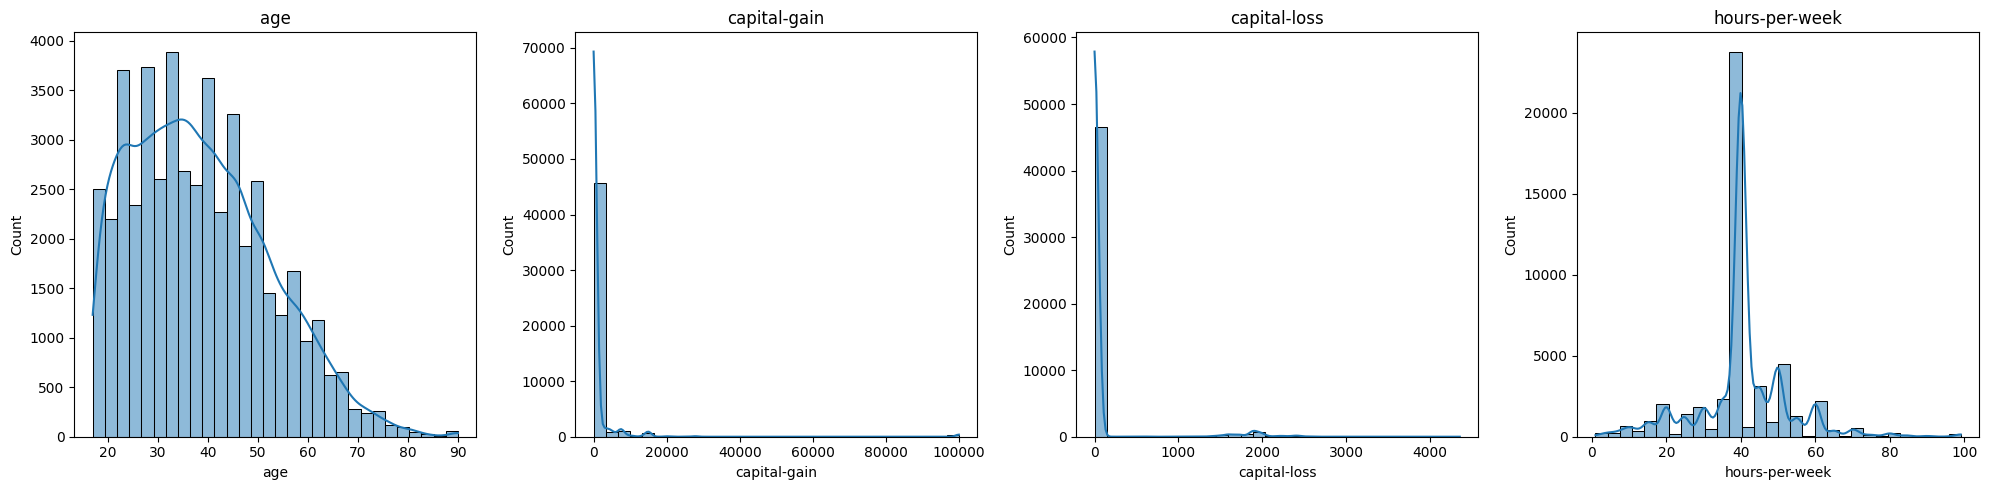

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

numericals = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, col in enumerate(numericals):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Splitting:

In [27]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns="class")
y = df["class"]

# Train - Validation - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.15, random_state=42)

In [28]:
# Handling Embedding Features Separately
from sklearn.preprocessing import OrdinalEncoder

embedding_features = ['workclass', 'occupation', 'native-country', 'education-num']
other_features = [col for col in X.columns if col not in embedding_features]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[embedding_features])

X_train_embed = encoder.transform(X_train[embedding_features])
X_val_embed = encoder.transform(X_val[embedding_features])
X_test_embed = encoder.transform(X_test[embedding_features])

In [29]:
pd.DataFrame(X_train_embed)

,0,1,2,3
0,3.0,11.0,38.0,8.0
1,3.0,7.0,38.0,5.0
2,3.0,0.0,38.0,8.0
3,1.0,10.0,38.0,12.0
4,8.0,14.0,38.0,6.0
...,...,...,...,...
34148,5.0,2.0,38.0,10.0
34149,3.0,7.0,27.0,4.0
34150,3.0,2.0,38.0,9.0
34151,6.0,0.0,38.0,10.0


preprocessing object (for other features):

In [30]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

to_one_hot = ['marital-status', 'relationship', 'race']
to_clip = ['hours-per-week']
to_log_transform = ['capital-gain', 'capital-loss']
to_scale = ['age']

clipper_transformer = Pipeline([
    ('clipper', FunctionTransformer(lambda x: np.clip(x, a_min=None, a_max=60))),
    ('scaler', StandardScaler())
])

log_transformer = Pipeline([
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), to_one_hot),
        ('clip', clipper_transformer, to_clip),
        ('log', log_transformer, to_log_transform),
        ('scale', StandardScaler(), to_scale)
    ],
    remainder= 'passthrough'
)

X_train_prep = preprocessor.fit_transform(X_train[other_features])
X_val_prep   = preprocessor.transform(X_val[other_features])
X_test_prep  = preprocessor.transform(X_test[other_features])

In [31]:
pd.set_option('display.max_columns', None)
pd.DataFrame(X_train_prep)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.912403,3.139482,-0.220333,0.024464,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.007695,-0.299581,-0.220333,-0.268261,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.007695,-0.299581,-0.220333,0.536732,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.455228,-0.299581,-0.220333,0.390370,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.254075,-0.299581,-0.220333,-1.512341,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34148,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-2.163604,-0.299581,-0.220333,1.122182,1.0
34149,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.364757,-0.299581,-0.220333,0.170826,1.0
34150,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.007695,-0.299581,-0.220333,-1.219617,1.0
34151,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.007695,-0.299581,-0.220333,0.536732,0.0



## Part 1: Optimizers
1. Train the same neural network using:
   - Stochastic Gradient Descent (SGD)
   - SGD with Momentum
   - Adam
2. Compare the training and validation accuracy for each optimizer.
3. Which optimizer converges the fastest? Which gives the best generalization?
4. Explain *why* Adam often performs better than plain SGD.

---


> Will use `Model` instead of `Sequential`, because the input will be merged (embedding features + other features)

## Part 2: Batch Size
1. Train the same model with different batch sizes (e.g., 1, 32, 128, 1024).
2. Compare:
   - Training speed
   - Validation accuracy
   - Test accuracy
   - Generalization ability
3. Which batch size leads to the **noisiest gradient updates**?
4. Which batch size generalizes better and why?


## Part 3: Overfitting and Regularization
1. Train a large neural network (many parameters) on the dataset.
2. Observe training vs. validation accuracy.  
   - Do you see signs of overfitting?
3. Apply regularization techniques:
   - **L2 regularization**
   - **Dropout**
4. Compare the validation results before and after regularization.
5. Which regularization method was more effective in reducing overfitting? Why?

---


## Part 4: Early Stopping
1. Train the model for many epochs without early stopping.  
   - Plot training, validation, and test curves.
2. Train again with **early stopping** (monitor validation loss).
3. Compare the number of epochs trained and the final validation/test accuracy.
4. Explain how early stopping helps prevent overfitting.

---

## Part 5: Reflection
1. Summarize what you learned about:
   - The role of optimizers
   - The effect of batch size
   - Regularization methods
   - Early stopping
   - Train/validation/test splits
2. If you had to train a deep learning model on a new tabular dataset, what choices would you make for:
   - Optimizer
   - Batch size
   - Regularization
   - Early stopping
   - Data splitting strategy  
   and why?